In [85]:
# Seed value
# Apparently you may use different seed values at each stage
seed_value= 0

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
import os
%env PYTHONHASHSEED=0

# 2. Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(seed_value)
# for later versions: 
# tf.compat.v1.set_random_seed(seed_value)

# 5. Configure a new global `tensorflow` session

# for later versions:
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

env: PYTHONHASHSEED=0


In [86]:
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics

from tensorflow.keras.layers import Input, Conv1D, Conv2D, Flatten, Dense, Conv1DTranspose, Conv2DTranspose, Reshape, Lambda, Activation, BatchNormalization, LeakyReLU, Dropout, ReLU, Masking, Concatenate, Layer
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import Zeros
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import plot_model

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.python.keras import regularizers

from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance

import lime.lime_tabular

import re

from sklearn.model_selection import train_test_split

import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)

In [87]:
meta = pd.read_csv("Data/cdiff_meta_COMBINED.txt", sep = "\t")

#bacterial datasets
bacteria = pd.read_csv("Data/filtered_species_table-NEW.txt", sep = "\t")
bacteria_species = pd.read_csv("Data/ALL-SPECIES-species-ed_lefse_CDIStatus-k2-full.txt.2.txt", sep = "\t")

#fungal datasets
fungi = pd.read_csv("Data/filtered_species_table-FUNGI.txt", sep = "\t")
fungi_species = pd.read_csv("Data/FUNGI-SPECIES-species-lefse_CDIStatus-k2-fungi.txt.2.txt", sep = "\t")
fungi_genes = pd.read_csv("Data/FUNGI-GENES-ed_renamed_lefse_CDIStatus-genes-emapper-fungi.txt.2.txt", sep = "\t")
full_fungi = pd.read_csv("Data/taxa-expression-profile-FUNGI.txt", sep = "\t")

#combined datasets
combined = pd.read_csv("Data/table-hits-combined.txt", sep = "\t")
combined_genes = pd.read_csv("Data/ALL-GENES-renamed_lefse_CDIStatus-emapper-full.txt", sep = "\t")

In [88]:
fungi_species_name = []
for species in fungi_species["Species"]:
    species = species.split('.')
    species = ';'.join(species)
    fungi_species_name.append(species)

In [89]:
# transpose fungi data
fungi = fungi.set_index("SampleID")
fungi = fungi.transpose()
fungi.index = fungi.index.map(int)

In [90]:
fungi = fungi[fungi_species_name]

In [91]:
# sort by index
fungi = fungi.sort_index()

In [92]:
# transpose fungi data
full_fungi = full_fungi.set_index("SampleID")
full_fungi = full_fungi.transpose()
full_fungi.index = full_fungi.index.map(int)

In [93]:
full_fungi = full_fungi[fungi_genes["GeneID"]]
full_fungi.shape

(39, 52)

In [94]:
full_fungi = full_fungi.sort_index()
full_fungi_names = full_fungi.columns

In [95]:
bacteria_species_names = []
for name in bacteria_species["Species"]:
    name = re.sub("[^0-9a-zA-Z]+", "_", name)
    bacteria_species_names.append(name)

In [96]:
# transpose bacteria data
bacteria = bacteria.set_index("SampleID")
bacteria = bacteria.transpose()

In [97]:
# get sample indexes
sample_ids = list(bacteria.index)

In [98]:
# sort by index
bacteria.index = bacteria.index.map(int)
bacteria = bacteria.sort_index()

In [99]:
new_col_names = []
for name in bacteria.columns:
    name = re.sub("[^0-9a-zA-Z]+", "_", name)
    new_col_names.append(name)
    
bacteria.columns = new_col_names

In [100]:
bacteria = bacteria[bacteria_species_names]

In [101]:
bacteria.shape

(39, 222)

In [102]:
# transpose combined data
combined = combined.set_index("SampleID")
combined = combined.transpose()
combined.index = combined.index.map(int)

In [103]:
combined = combined[combined_genes["GeneID"]]
combined.shape

(39, 130)

In [104]:
combined = combined.sort_index()
combined_names = combined.columns

In [105]:
meta = meta[meta["SampleID"].isin(sample_ids)]

In [106]:
# make output vector (positive/negative) from metadata
y = [1 if i == 'Positive' else 0 for i in meta["CDIStatus"]]
y = np.array(y)
y = y.astype("float32")

In [107]:
#convert to numpy array
fungi = np.array(fungi)
fungi = fungi.astype("float32")

full_fungi = np.array(full_fungi)
full_fungi = full_fungi.astype("float32")

combined = np.array(combined)
combined = combined.astype("float32")

bacteria = np.array(bacteria)
bacteria = bacteria.astype("float32")

In [108]:
combined_species = np.array(np.hstack([fungi, bacteria]))
combined_species.shape

(39, 233)

In [109]:
combined_species_names = fungi_species_name + bacteria_species_names

Scores for each fold are: [0.75       1.         0.5        1.         1.         0.75
 1.         0.5        0.75       1.         1.         0.75
 0.75       0.75       1.         1.         0.75       1.
 0.75       0.66666667 1.         1.         0.75       1.
 1.         0.75       1.         0.75       0.5        1.
 1.         0.75       1.         0.75       1.         0.75
 1.         1.         0.75       0.66666667 1.         0.75
 0.75       1.         0.5        0.75       0.75       1.
 0.75       1.        ]
Average score: 0.847 (+/-0.161)


<AxesSubplot:>

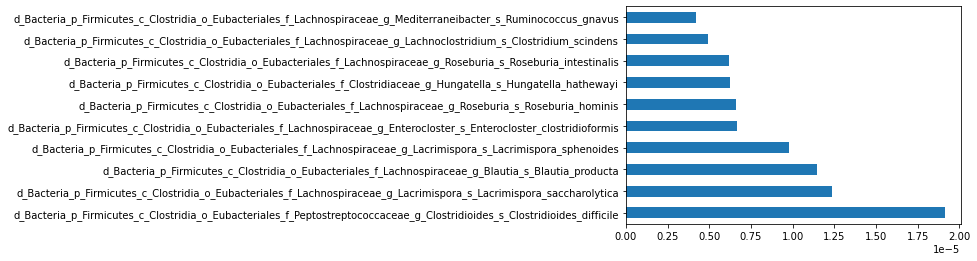

In [110]:
# Linear SVM
from sklearn import svm
from sklearn import metrics
import matplotlib.pyplot as plt

clf = svm.SVC(kernel = 'linear', C = 1)
clf.fit(combined_species, y)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=1)
score = cross_val_score(clf, combined_species, y, scoring='accuracy', cv=cv)

# report performance
print(f'Scores for each fold are: {score}')
print(f'Average score: {"{:.3f} (+/-{:.3f})".format(score.mean(), score.std())}')

pd.Series(abs(clf.coef_[0]), index=combined_species_names).nlargest(10).plot(kind='barh')


<AxesSubplot:>

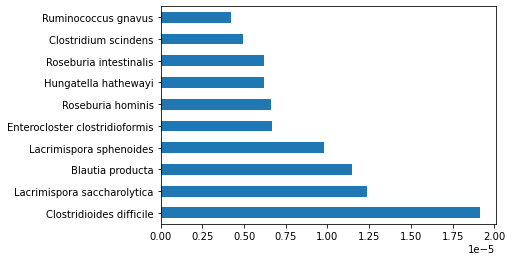

In [111]:
## SVM Viz.
svm_names = ['Clostridioides difficile',
             'Lacrimispora saccharolytica',
             'Blautia producta',
             'Lacrimispora sphenoides',
             'Enterocloster clostridioformis',
             'Roseburia hominis',
             'Hungatella hathewayi',
             'Roseburia intestinalis',
             'Clostridium scindens',
             'Ruminococcus gnavus']

svm_feats = pd.Series(abs(clf.coef_[0]), index=combined_species_names).nlargest(10)
svm_feats.set_axis(svm_names).plot(kind='barh')

Scores for each fold are: [0.75       1.         0.75       0.75       0.75       0.75
 1.         0.5        0.75       0.66666667 1.         0.75
 0.75       0.75       1.         0.75       0.5        1.
 0.75       0.66666667 0.75       1.         0.75       0.75
 1.         0.75       0.5        0.75       0.75       1.
 1.         0.75       1.         0.75       1.         0.75
 0.75       0.75       0.5        1.         1.         0.75
 0.75       0.75       0.75       1.         1.         1.
 0.75       0.33333333]
Average score: 0.798 (+/-0.163)


<AxesSubplot:>

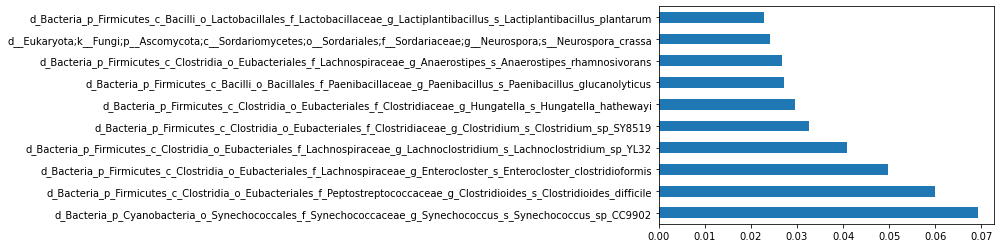

In [112]:
# Random Forest 
clf = RandomForestClassifier()
clf.fit(combined_species, y)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=1)
score = cross_val_score(clf, combined_species, y, scoring='accuracy', cv=cv)

# report performance
print(f'Scores for each fold are: {score}')
print(f'Average score: {"{:.3f} (+/-{:.3f})".format(score.mean(), score.std())}')

pd.Series(abs(clf.feature_importances_), index=combined_species_names).nlargest(10).plot(kind='barh')

<AxesSubplot:>

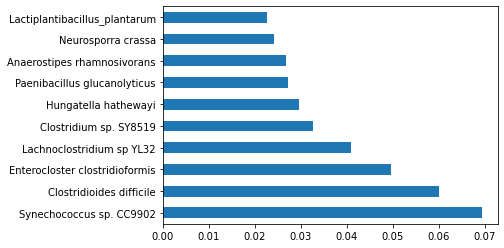

In [117]:
## RF Viz.
rf_names = ['Synechococcus sp. CC9902',
            'Clostridioides difficile',
            'Enterocloster clostridioformis',
            'Lachnoclostridium sp YL32',
            'Clostridium sp. SY8519',
            'Hungatella hathewayi',
            'Paenibacillus glucanolyticus',
            'Anaerostipes rhamnosivorans',
            'Neurosporra crassa',
            'Lactiplantibacillus_plantarum']

rf_feats = pd.Series(abs(clf.feature_importances_), index=combined_species_names).nlargest(10)
rf_feats.set_axis(rf_names).plot(kind='barh')

In [28]:
# Now with cross-validation
# Begin K-fold Cross-Validation
kfold = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 5, random_state = 0)
cvacc = []
cvauc = []

# create model with CV compatibility
for train, test in kfold.split(combined_species, y):
    
    model = Sequential([
        Lambda(lambda x: K.log(K.cast((1 + x * 1000), "float32"))/K.log(K.cast((1 + 1000), "float32"))),
        Dense(500, activation = 'softplus', kernel_regularizer=tf.keras.regularizers.l1(.001)),
        Dropout(.4),
        BatchNormalization(),
        Dense(500, activation = 'softplus', kernel_regularizer=tf.keras.regularizers.l1(.001)),
        Dropout(.4),
        BatchNormalization(),
        Dense(500, activation = 'softplus', kernel_regularizer=tf.keras.regularizers.l1(.001)),
        Dropout(.4),
        BatchNormalization(),
        Dense(500, activation = 'softplus', kernel_regularizer=tf.keras.regularizers.l1(.001)),
        Dropout(.4),
        BatchNormalization(),
        Dense(500, activation = 'softplus', kernel_regularizer=tf.keras.regularizers.l1(.001)),
        Dropout(.4),
        BatchNormalization(),
        Dense(500, activation = 'softplus', kernel_regularizer=tf.keras.regularizers.l1(.001)),
        Dropout(.4),
        BatchNormalization(),
        Dense(1, activation = 'sigmoid')
    ])
    
    model.compile(optimizer = "Adam",
                  loss = "binary_crossentropy",
                  metrics = ["accuracy"])
    
    model.fit(combined_species[train], y[train],
              epochs = 1000,
              validation_split = .2,
              verbose = 0)
    
    train_result = model.evaluate(combined_species[train], y[train], verbose = 0)
    print("train {:s}: {:.2%} ".format(model.metrics_names[1], train_result[1]))
    
    result = model.evaluate(combined_species[test], y[test], verbose = 0)
    print("{:s}: {:.2%} \n".format(model.metrics_names[1], result[1]))
    
    cvacc.append(result[1])
    
print("Accuracy: {:.2%} (+/-{:.2%})".format(np.mean(cvacc), np.std(cvacc)))

train accuracy: 97.14% 
accuracy: 100.00% 

train accuracy: 100.00% 
accuracy: 75.00% 

train accuracy: 97.14% 
accuracy: 75.00% 

train accuracy: 94.29% 
accuracy: 75.00% 

train accuracy: 94.29% 
accuracy: 100.00% 

train accuracy: 100.00% 
accuracy: 100.00% 

train accuracy: 97.14% 
accuracy: 50.00% 

train accuracy: 97.14% 
accuracy: 75.00% 

train accuracy: 97.14% 
accuracy: 75.00% 

train accuracy: 97.22% 
accuracy: 66.67% 

train accuracy: 100.00% 
accuracy: 100.00% 

train accuracy: 100.00% 
accuracy: 75.00% 

train accuracy: 94.29% 
accuracy: 100.00% 

train accuracy: 100.00% 
accuracy: 100.00% 

train accuracy: 94.29% 
accuracy: 75.00% 

train accuracy: 97.14% 
accuracy: 75.00% 

train accuracy: 97.14% 
accuracy: 100.00% 

train accuracy: 100.00% 
accuracy: 75.00% 

train accuracy: 97.14% 
accuracy: 50.00% 

train accuracy: 94.44% 
accuracy: 100.00% 

train accuracy: 94.29% 
accuracy: 75.00% 

train accuracy: 100.00% 
accuracy: 75.00% 

train accuracy: 97.14% 
accuracy: 75.00

## Combined Data Without C. Diff

In [28]:
combined_species = pd.DataFrame(combined_species, columns=combined_species_names)

In [29]:
c_diff_col = [col for col in combined_species.columns if 'Clostridioides_difficile' in col]

del combined_species[c_diff_col[0]]
combined_species.shape

combined_species_names.remove(c_diff_col[0])

In [30]:
len(combined_species_names)

232

Scores for each fold are: [1.         1.         0.75       0.75       0.75       0.5
 1.         0.75       1.         1.         0.75       1.
 0.75       1.         1.         1.         0.75       0.75
 1.         0.66666667 1.         1.         0.75       0.75
 1.         1.         0.75       0.75       0.5        0.66666667
 1.         0.75       1.         1.         1.         0.5
 0.5        0.75       0.75       0.66666667 1.         1.
 1.         0.75       0.75       0.75       0.75       0.75
 0.75       0.66666667]
Average score: 0.828 (+/-0.160)


<AxesSubplot:>

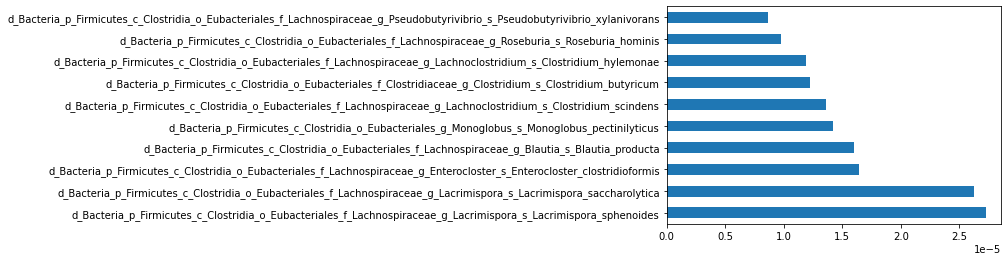

In [31]:
# Linear SVM
from sklearn import svm
from sklearn import metrics
import matplotlib.pyplot as plt

clf = svm.SVC(kernel = 'linear', C = 1)
clf.fit(combined_species, y)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=1)
score = cross_val_score(clf, combined_species, y, scoring='accuracy', cv=cv)

# report performance
print(f'Scores for each fold are: {score}')
print(f'Average score: {"{:.3f} (+/-{:.3f})".format(score.mean(), score.std())}')

pd.Series(abs(clf.coef_[0]), index=combined_species_names).nlargest(10).plot(kind='barh')


In [ ]:
## SVM viz for paper
svm_names = ['Lacrimispora sphenoides',
             'Lacrimispora saccharolytica',
             'Enterocloster clostridioformis',
             'Blautia producta',
             'Monoglobus pectinilyticus',
             'Clostridium scindens',
             'Clostridium butyricum',
             'Clostridium hylemonae',
             'Roseburia hominis'
             'Pseudobutyrivibrio xylanivorans']


pd.Series(abs(clf.coef_[0]), index=svm_names).nlargest(10).plot(kind='barh')

Scores for each fold are: [1.         1.         0.75       0.75       0.75       0.75
 1.         0.75       0.75       0.66666667 1.         0.75
 0.75       1.         1.         0.75       0.75       1.
 0.75       0.33333333 1.         1.         0.75       0.75
 0.75       1.         0.25       0.75       0.75       1.
 1.         0.75       0.75       0.5        1.         0.75
 0.75       0.75       0.5        1.         1.         1.
 0.75       0.75       0.5        1.         1.         1.
 0.5        0.33333333]
Average score: 0.797 (+/-0.197)


<AxesSubplot:>

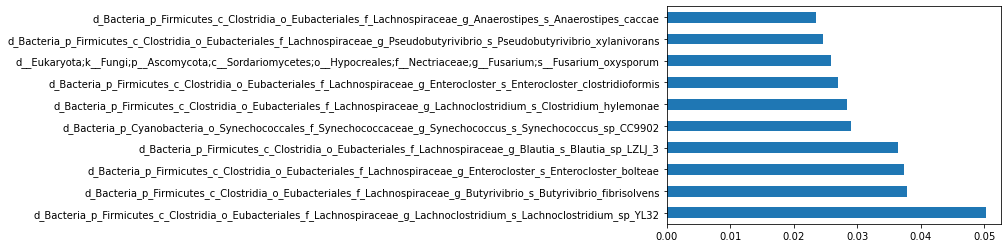

In [32]:
# Random Forest 
clf = RandomForestClassifier()
clf.fit(combined_species, y)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=1)
score = cross_val_score(clf, combined_species, y, scoring='accuracy', cv=cv)

# report performance
print(f'Scores for each fold are: {score}')
print(f'Average score: {"{:.3f} (+/-{:.3f})".format(score.mean(), score.std())}')

pd.Series(abs(clf.feature_importances_), index=combined_species_names).nlargest(10).plot(kind='barh')

In [ ]:
## RF Paper Viz.
rf_names = ['Lachnoclostridium sp. YL32',
            'Butyrivibrio fibrisolvens',
            'Blautia sp. LZLJ 3',
            'Synechococcus sp. CC9902',
            'Clostridium Hylemonae',
            'Enterocloster clostridioformis,'
            'Fusarium oxysporum',
            'Pseudobutyrvibrio xylanivorans',
            'Anaerostipes caccae']

pd.Series(abs(clf.feature_importances_), index=rf_names).nlargest(10).plot(kind='barh')

In [33]:
# Now with cross-validation
# Begin K-fold Cross-Validation
kfold = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 5, random_state = 0)
cvacc = []
cvauc = []

combined_species = np.array(combined_species)

# create model with CV compatibility
for train, test in kfold.split(combined_species, y):
    
    model = Sequential([
        Lambda(lambda x: K.log(K.cast((1 + x * 1000), "float32"))/K.log(K.cast((1 + 1000), "float32"))),
        Dense(500, activation = 'softplus', kernel_regularizer=tf.keras.regularizers.l1(.001)),
        Dropout(.4),
        BatchNormalization(),
        Dense(500, activation = 'softplus', kernel_regularizer=tf.keras.regularizers.l1(.001)),
        Dropout(.4),
        BatchNormalization(),
        Dense(500, activation = 'softplus', kernel_regularizer=tf.keras.regularizers.l1(.001)),
        Dropout(.4),
        BatchNormalization(),
        Dense(500, activation = 'softplus', kernel_regularizer=tf.keras.regularizers.l1(.001)),
        Dropout(.4),
        BatchNormalization(),
        Dense(500, activation = 'softplus', kernel_regularizer=tf.keras.regularizers.l1(.001)),
        Dropout(.4),
        BatchNormalization(),
        Dense(500, activation = 'softplus', kernel_regularizer=tf.keras.regularizers.l1(.001)),
        Dropout(.4),
        BatchNormalization(),
        Dense(1, activation = 'sigmoid')
    ])
    
    model.compile(optimizer = "Adam",
                  loss = "binary_crossentropy",
                  metrics = ["accuracy"])
    
    model.fit(combined_species[train], y[train],
              epochs = 1000,
              validation_split = .2,
              verbose = 0)
    
    train_result = model.evaluate(combined_species[train], y[train], verbose = 0)
    print("train {:s}: {:.2%} ".format(model.metrics_names[1], train_result[1]))
    
    result = model.evaluate(combined_species[test], y[test], verbose = 0)
    print("{:s}: {:.2%} \n".format(model.metrics_names[1], result[1]))
    
    cvacc.append(result[1])
    
print("Accuracy: {:.2%} (+/-{:.2%})".format(np.mean(cvacc), np.std(cvacc)))

train accuracy: 97.14% 
accuracy: 100.00% 

train accuracy: 97.14% 
accuracy: 75.00% 

train accuracy: 97.14% 
accuracy: 75.00% 

train accuracy: 94.29% 
accuracy: 75.00% 

train accuracy: 94.29% 
accuracy: 100.00% 

train accuracy: 100.00% 
accuracy: 100.00% 

train accuracy: 97.14% 
accuracy: 50.00% 

train accuracy: 97.14% 
accuracy: 75.00% 

train accuracy: 97.14% 
accuracy: 100.00% 

train accuracy: 97.22% 
accuracy: 66.67% 

train accuracy: 100.00% 
accuracy: 100.00% 

train accuracy: 100.00% 
accuracy: 75.00% 

train accuracy: 94.29% 
accuracy: 100.00% 

train accuracy: 100.00% 
accuracy: 100.00% 

train accuracy: 94.29% 
accuracy: 75.00% 

train accuracy: 97.14% 
accuracy: 75.00% 

train accuracy: 97.14% 
accuracy: 100.00% 

train accuracy: 100.00% 
accuracy: 75.00% 

train accuracy: 97.14% 
accuracy: 50.00% 

train accuracy: 94.44% 
accuracy: 66.67% 

train accuracy: 94.29% 
accuracy: 75.00% 

train accuracy: 100.00% 
accuracy: 75.00% 

train accuracy: 97.14% 
accuracy: 75.00%